In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch as ch
from nff.io import EnsembleNFF, NeuralFF
from nff.utils.cuda import batch_to

/home/dux/miniconda3/envs/htvs/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load neural network force field. We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039).

In [2]:
if ch.cuda.is_available():
    DEVICE = 0
else:
    DEVICE = "cpu"

DATAPATH = os.path.join(os.getcwd(), "SrTiO3")
offset_data = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]
models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

model = models[0]  # use just one model for clustering
ensemble = EnsembleNFF(models, device=DEVICE)

Load surfaces previously obtained from VSSR-MC

In [3]:
structures = open("data/SrTiO3_001_2x2_mcmc_structures_100.pkl", "rb")
dataset = pickle.load(structures)

print(f"Final dataset has {len(dataset)} entries")

Final dataset has 100 entries


Extract relevant data

In [4]:
def extract_nff_data(
    combined_embeddings,
    combined_force_std,
    combined_energy_std,
    combined_pred_energy,
    atoms,
):
    batch = batch_to(atoms.get_batch(), DEVICE)
    list_num_atoms = batch["num_atoms"].detach().cpu().tolist()

    # for model in models:
    atomwise_out, xyz, r_ij, nbrs = model.atomwise(batch=batch)
    split_features = ch.split(atomwise_out["features"], list_num_atoms)
    summed_split_features = [
        atom_features.sum(axis=0).detach().cpu().numpy()
        for atom_features in split_features
    ]
    combined_embeddings.extend(summed_split_features)

    ensemble.calculate(atoms)
    split_forces_std = ch.split(
        ch.from_numpy(ensemble.results["forces_std"]), list_num_atoms
    )
    split_forces_std_avg = [std.mean().tolist() for std in split_forces_std]

    combined_force_std.extend(split_forces_std_avg)
    combined_energy_std.extend(ensemble.results["energy_std"])
    combined_pred_energy.extend(ensemble.results["energy"])

In [5]:
embeddings = []
force_std = []
energy_std = []
pred_energy = []

for atoms in dataset:
    extract_nff_data(
        embeddings,
        force_std,
        energy_std,
        pred_energy,
        atoms,
    )

Obtain PCA

In [6]:
X_embeddings = np.stack(embeddings)

from sklearn.decomposition import PCA

pca = PCA(n_components=32, whiten=True).fit(X_embeddings)

print(f"The pca explained ratios are {pca.explained_variance_ratio_[:5]}...")

# transform train
X_r = pca.transform(X_embeddings)

The pca explained ratios are [0.68285704 0.2713578  0.01691276 0.00785861 0.00560058]...


Do clustering

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(X_r[:, :3], method="ward", metric="euclidean", optimal_ordering=True)
y = fcluster(Z, t=2, criterion="distance", depth=2)  # t sets the distance
clusters = np.unique(y)
max_index = np.max(clusters)

print(f"There are {len(clusters)} clusters")

There are 13 clusters


Visualize with dendrogram

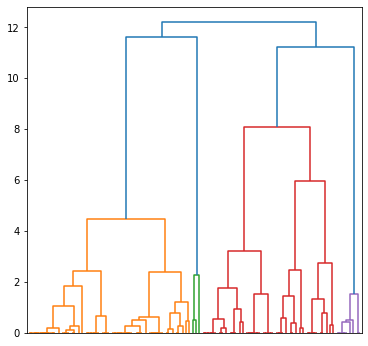

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(6, 6))
dn = dendrogram(
    Z,
    truncate_mode="level",
    show_leaf_counts=False,
    no_labels=True,
    count_sort="descending",
)
plt.show()

Find structure with the highest variance per cluster

In [9]:
data = {"cluster": y, "force_std": force_std}

df = pd.DataFrame(data).reset_index()

max_std_df = (
    df.sort_values(["cluster", "force_std"], ascending=[True, False])
    .groupby("cluster", as_index=False)
    .first()
)

PCA plot with the highest variance structure per cluster

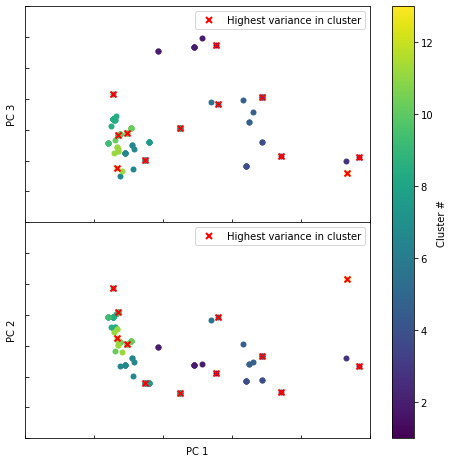

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)

for cluster in clusters:
    axes[1].scatter(
        X_r[y == cluster, 0],
        X_r[y == cluster, 1],
        edgecolors=None,
        linewidths=0,
        color=mpl.cm.viridis(cluster / max_index),
    )
    axes[0].scatter(
        X_r[y == cluster, 0],
        X_r[y == cluster, 2],
        edgecolors=None,
        linewidths=0,
        color=mpl.cm.viridis(cluster / max_index),
    )

# highlight max variance per cluster
for idx in max_std_df["index"]:
    axes[1].scatter(X_r[idx, 0], X_r[idx, 1], linewidths=2, color="r", marker="x")
    axes[0].scatter(X_r[idx, 0], X_r[idx, 2], linewidths=2, color="r", marker="x")

for ax in axes:
    # increase tick size and make them point inwards
    ax.tick_params(
        axis="y",
        direction="in",
    )
    ax.tick_params(
        axis="x",
        direction="in",
    )

# set axes for first plot
axes[0].set_ylabel("PC 3")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_xlim([-2, 3])
axes[0].set_ylim([-3, 4])

# set axes for second plot
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")
axes[1].set_yticklabels([])
axes[1].set_ylim([-3, 4])

norm = mpl.colors.Normalize(vmin=min(clusters), vmax=max(clusters))
cb = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap="viridis"),
    ax=axes.ravel().tolist(),
    shrink=1.00,
)
cb.set_label(r"Cluster #")

cb.ax.tick_params(
    axis="both",
    which="major",
)
cb.ax.tick_params(
    axis="both",
    which="minor",
)

from matplotlib.lines import Line2D

scatter_leg = (
    Line2D(
        [0],
        [0],
        marker="x",
        lw=0,
        markeredgewidth=2,
        markeredgecolor="r",
    ),
)

labels = ["Highest variance in cluster"]
handles = scatter_leg

for ax in axes:
    ax.legend(handles, labels, loc="best", frameon=True)

plt.show()
plt.close()